In [1]:
from google.cloud import bigquery
import pandas as pd

In [2]:
# Construct a BigQuery client object.
client = bigquery.Client(project='pybigquery')

In [55]:
# Creat the table that is used for finding a good striker for Chelsea

query = """

    CREATE TABLE pybigquery.Football_Transfer.topleagueplayer AS
    
        WITH tem AS (
            SELECT 
                *,
                CASE
                    WHEN date BETWEEN  '2021-08-14' AND '2022-06-30' THEN 1
                    WHEN date BETWEEN  '2022-07-01' AND '2023-06-30' THEN 2
                END AS season
            FROM (
                SELECT
                    player_name,
                    player_id,
                    player_club_id,
                    goals,
                    assists,
                    minutes_played,
                    yellow_cards,
                    red_cards,
                    date
                FROM 
                    `pybigquery.Football_Transfer.appearances`
                WHERE
                    date BETWEEN '2021-08-14' AND '2023-06-30'
                )
        ), player_stats AS (
            SELECT 
                player_name, player_id, player_club_id,
                season, SUM(goals) AS total_goals,
                SUM(assists) AS total_assists,
                SUM(yellow_cards) as yellow_cards,
                SUM(red_cards) as red_cards,
                SUM(minutes_played) as minutes_played
            FROM 
                tem 
            GROUP BY
                player_name, player_id, player_club_id, season
            )

        SELECT 
            ps.season, ps.player_id, ps.player_name, ps.total_goals, ps.total_assists, ps.yellow_cards, ps.red_cards,
            ps.minutes_played, club.name AS club_name, club.domestic_competition_id, player.foot, player.height_in_cm, player.position, 
            player.sub_position, player.market_value_in_eur, player.contract_expiration_date, 
            DATE_DIFF('2022-07-01', player.date_of_birth, year) AS current_age, player.agent_name 
        FROM 
            player_stats ps
        INNER JOIN (
            SELECT 
                club_id, domestic_competition_id, name
            FROM 
                `pybigquery.Football_Transfer.clubs`
            WHERE 
                domestic_competition_id = 'GB1' OR
                domestic_competition_id = 'ES1' OR
                domestic_competition_id = 'FR1' OR
                domestic_competition_id = 'L1' OR
                domestic_competition_id = 'IT1' OR
                domestic_competition_id = 'PO1'
        ) AS club
            ON ps.player_club_id = club.club_id
        INNER JOIN `pybigquery.Football_Transfer.players` player
            ON player.player_id = ps.player_id

"""


query_job = client.query(query)  
#df = query_job.to_dataframe()
#df.head()


In [56]:
# 'Centre-Forward', 'Second Striker', 'Attacking Midfield'

query = ''' 

SELECT *
FROM `pybigquery.Football_Transfer.topleagueplayer`
WHERE sub_position = 'Centre-Forward' OR sub_position =  'Second Striker' OR sub_position =  'Attacking Midfield'

'''

query_job = client.query(query)  
df = query_job.to_dataframe()
df.head(5)

# 

,season,player_id,player_name,total_goals,total_assists,yellow_cards,red_cards,minutes_played,club_name,domestic_competition_id,foot,height_in_cm,position,sub_position,market_value_in_eur,contract_expiration_date,current_age,agent_name
0,2,401931,Jô,2,0,5,0,405,GD Chaves,PO1,left,192,Attack,Centre-Forward,25000,2024-06-30 00:00:00+00:00,27,None
1,2,503212,Aziz,9,3,2,0,1368,Rio Ave FC,PO1,right,187,Attack,Centre-Forward,2000000,2023-12-31 00:00:00+00:00,24,10Management
2,1,595809,Beto,11,0,2,0,2230,Udinese Calcio,IT1,right,194,Attack,Centre-Forward,25000000,2026-06-30 00:00:00+00:00,24,PR10
3,2,595809,Beto,10,2,2,0,2195,Udinese Calcio,IT1,right,194,Attack,Centre-Forward,25000000,2026-06-30 00:00:00+00:00,24,PR10
4,1,595809,Beto,1,0,0,0,179,Portimonense SC,PO1,right,194,Attack,Centre-Forward,25000000,2026-06-30 00:00:00+00:00,24,PR10


In [30]:

query = ''' 

-- One player can play for 2 clubs within a season (Join another club in Jan Transfer window)

CREATE TABLE pybigquery.Football_Transfer.targetplayer AS

WITH stats AS(
    SELECT 
        player_id, 
        player_name,
        current_age,
        height_in_cm,
        domestic_competition_id,
        club_name,
        SUM(total_goals) OVER (PARTITION BY player_id, season) AS last_season_goals,
        SUM(total_assists) OVER (PARTITION BY player_id, season) AS last_season_assists,
        SUM(yellow_cards) OVER (PARTITION BY player_id, season) AS last_season_yellow,
        SUM(red_cards) OVER (PARTITION BY player_id, season) AS last_season_red,
        minutes_played,
        market_value_in_eur,
        contract_expiration_date,
        agent_name
    FROM 
        `pybigquery.Football_Transfer.topleagueplayer`
    WHERE 
        (sub_position = 'Centre-Forward' OR sub_position =  'Second Striker') -- OR sub_position =  'Attacking Midfield') 
        AND minutes_played >= 2565
        AND season = 2
        AND club_name NOT LIKE '%Chelsea%'
        AND current_age < 32 
), more_stats AS(

    SELECT 
        *, 
        Ceil(minutes_played/90) AS game_played,
        last_season_goals/(minutes_played/90) AS goal_per_game,
        last_season_assists/(minutes_played/90) AS assist_per_game
    FROM 
        stats
    
)



    SELECT
        player_id,
        player_name,
        current_age,
        height_in_cm,
        domestic_competition_id,    
        club_name,
        game_played,
        minutes_played, 
        goal_per_game, 
        last_season_goals, 
        assist_per_game, 
        last_season_assists, 
        market_value_in_eur,
        market_value_in_eur / 1000000 AS market_value_in_million_eur
    FROM
        more_stats
    WHERE 
        goal_per_game >=0.26 AND assist_per_game >= 0.2
    ORDER BY 
        goal_per_game DESC

  

'''

query_job = client.query(query)  
df = query_job.to_dataframe()
df.head(5)

""


In [34]:
query = '''

WITH tem AS(
SELECT 
    *,
    CASE
        WHEN date BETWEEN  '2021-08-14' AND '2022-06-30' THEN 1
        WHEN date BETWEEN  '2022-07-01' AND '2023-06-30' THEN 2
    END AS season
FROM 
    `pybigquery.Football_Transfer.appearances`
WHERE
    (competition_id = 'GB1' OR
    competition_id = 'ES1' OR
    competition_id = 'FR1' OR
    competition_id = 'L1' OR
    competition_id = 'IT1' OR
    competition_id = 'PO1') AND 
    (date BETWEEN '2021-08-14' AND '2023-06-30')
), minute AS
(SELECT player_id, player_name,SUM(minutes_played) as club_play_minute
FROM tem
WHERE season = 2
GROUP BY player_id, player_name)

SELECT 
    player.player_id,
    player.player_name,
    player.current_age,
    player.height_in_cm,
    player.domestic_competition_id,    
    player.club_name,
    player.game_played,
    m.club_play_minute,
    player.minutes_played, 
    player.goal_per_game, 
    player.last_season_goals, 
    player.assist_per_game, 
    player.last_season_assists, 
    player.market_value_in_eur,
    player.market_value_in_million_eur
FROM 
    minute m
INNER JOIN pybigquery.Football_Transfer.targetplayer player
ON m.player_id = player.player_id



'''

query_job = client.query(query)  
df = query_job.to_dataframe()
df

,player_id,player_name,current_age,height_in_cm,domestic_competition_id,club_name,game_played,club_play_minute,minutes_played,goal_per_game,last_season_goals,assist_per_game,last_season_assists,market_value_in_eur,market_value_in_million_eur
0,487969,Randal Kolo Muani,24,187,L1,Eintracht Frankfurt,41.0,2647,3634,0.569620,23,0.421024,17,80000000,80.0
1,188888,Sheraldo Becker,27,180,L1,1.FC Union Berlin,42.0,2582,3749,0.288077,12,0.240064,10,17000000,17.0
2,318528,Marcus Thuram,25,192,L1,Borussia Mönchengladbach,30.0,2518,2698,0.533729,16,0.233506,7,32000000,32.0
3,125103,Marvin Ducksch,28,188,L1,SV Werder Bremen,33.0,2866,2956,0.365359,12,0.243572,8,7500000,7.5
4,75489,Niclas Füllkrug,29,189,L1,SV Werder Bremen,30.0,2479,2689,0.535515,16,0.200818,6,13000000,13.0
5,198008,André Silva,27,185,L1,RB Leipzig,29.0,1741,2582,0.313710,9,0.313710,9,15000000,15.0
6,344381,Christopher Nkunku,25,178,L1,RB Leipzig,31.0,1897,2733,0.757409,23,0.296378,9,80000000,80.0
7,418659,Amine Gouiri,22,181,FR1,Stade Rennais FC,34.0,2759,2985,0.512563,17,0.211055,7,35000000,35.0
8,340376,Abel Ruiz,22,182,PO1,SC Braga,31.0,2086,2756,0.326560,10,0.228592,7,10000000,10.0
9,125781,Antoine Griezmann,31,176,ES1,Atlético de Madrid,41.0,2860,3625,0.397241,16,0.471724,19,25000000,25.0


In [48]:
query = '''

WITH tem AS (
    SELECT 
        *,
        CASE
            WHEN date BETWEEN  '2019-07-01' AND '2020-06-30' THEN 1
            WHEN date BETWEEN  '2020-07-01' AND '2021-06-30' THEN 2
            WHEN date BETWEEN  '2021-07-01' AND '2022-06-30' THEN 3
            WHEN date BETWEEN  '2022-07-01' AND '2023-06-30' THEN 4
        END AS season
FROM
    pybigquery.Football_Transfer.appearances
), intermediate AS

(SELECT 
    player_id,
    player_name,
    season,
    SUM(minutes_played) OVER (PARTITION BY player_id ,season) AS playtime
FROM 
    tem
WHERE 
    season IS NOT NULL AND 
    (competition_id = 'GB1' OR
     competition_id = 'ES1' OR
     competition_id = 'FR1' OR
     competition_id = 'L1' OR
     competition_id = 'IT1' OR
     competition_id = 'PO1')), seasontime AS
     
(SELECT player_name, season, MAX(playtime) AS season_playtime
FROM intermediate 
GROUP BY player_name, season
ORDER BY player_name
)

SELECT 
    player_name, 
    season,
    season_playtime,
    CASE
        WHEN match_played < 1 THEN 1
        ELSE match_played
    END AS match_played
FROM (SELECT s.player_name, s.season, s.season_playtime, ROUND( CAST(s.season_playtime/90 AS NUMERIC), 0, "ROUND_HALF_EVEN") AS match_played 
FROM seasontime s
RIGHT JOIN pybigquery.Football_Transfer.targetplayer t
ON s.player_name = t.player_name
ORDER BY player_name, season)


'''

query_job = client.query(query)  
df = query_job.to_dataframe()
df.head(10)

,player_name,season,season_playtime,match_played
0,Abel Ruiz,1,22,1.000000000
1,Abel Ruiz,2,1381,15.000000000
2,Abel Ruiz,3,1378,15.000000000
3,Abel Ruiz,4,2086,23.000000000
4,Amine Gouiri,1,1,1.000000000
5,Amine Gouiri,2,2753,31.000000000
6,Amine Gouiri,3,2764,31.000000000
7,Amine Gouiri,4,2759,31.000000000
8,André Silva,1,1641,18.000000000
9,André Silva,2,2773,31.000000000


In [50]:
df.to_feather('../../Data Source/Football Transfer/TopScorer_Playtime')

In [52]:
player = pd.read_feather('../../Data Source/Football Transfer/TopScorer_Playtime')

In [53]:
player.head()

,player_name,season,season_playtime,match_played
0,Abel Ruiz,1,22,1.000000000
1,Abel Ruiz,2,1381,15.000000000
2,Abel Ruiz,3,1378,15.000000000
3,Abel Ruiz,4,2086,23.000000000
4,Amine Gouiri,1,1,1.000000000


In [12]:
query = '''

SELECT * 
FROM `pybigquery.Football_Transfer.competitions`
LIMIT 10

'''

query_job = client.query(query)  
df = query_job.to_dataframe()
df.head()

,competition_id,competition_code,name,sub_type,type,country_id,country_name,domestic_league_code,confederation,url
0,USC,uefa-super-cup,uefa-super-cup,uefa_super_cup,other,-1,None,None,europa,https://www.transfermarkt.co.uk/uefa-super-cup...
1,EL,europa-league,europa-league,europa_league,international_cup,-1,None,None,europa,https://www.transfermarkt.co.uk/europa-league/...
2,ELQ,europa-league-qualifikation,europa-league-qualifikation,europa_league_qualifying,international_cup,-1,None,None,europa,https://www.transfermarkt.co.uk/europa-league-...
3,ECLQ,uefa-europa-conference-league-qualifikation,uefa-europa-conference-league-qualifikation,uefa_europa_conference_league_qualifiers,international_cup,-1,None,None,europa,https://www.transfermarkt.co.uk/uefa-europa-co...
4,CL,uefa-champions-league,uefa-champions-league,uefa_champions_league,international_cup,-1,None,None,europa,https://www.transfermarkt.co.uk/uefa-champions...


### Generate dataset that used for comparison of Chelsea goal scoring performance

1. club-games
2. club
3. appearances

In [119]:
query = '''

SELECT * 
FROM `pybigquery.Football_Transfer.appearances`
LIMIT 10

'''

query_job = client.query(query)  
df = query_job.to_dataframe()
df.head()

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2460589_237947,2460589,237947,11411,16247,2014-07-01,Rumyan Hovsepyan,CLQ,0,0,0,0,90
1,2460592_237947,2460592,237947,11411,16247,2014-07-08,Rumyan Hovsepyan,CLQ,1,0,2,0,90
2,2460598_127770,2460598,127770,12469,6994,2014-07-15,Nurudeen Orelesi,CLQ,1,0,0,0,90
3,2460598_53228,2460598,53228,713,3729,2014-07-15,Anri Khagush,CLQ,0,0,0,0,70
4,2460598_53238,2460598,53238,713,347,2014-07-15,Sergey Krivets,CLQ,1,0,0,0,70


In [16]:
query = '''

SELECT * 
FROM `pybigquery.Football_Transfer.clubs`
WHERE domestic_competition_id = 'GB1'
LIMIT 10

'''

query_job = client.query(query)  
df = query_job.to_dataframe()
df.head()

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,last_season,url
0,641,fc-middlesbrough,Middlesbrough FC,GB1,None,25,26.1,8,32.0,6,Riverside Stadium,33746,+€16.68m,None,2016,https://www.transfermarkt.co.uk/fc-middlesbrou...
1,984,west-bromwich-albion,West Bromwich Albion,GB1,None,25,27.8,8,32.0,4,The Hawthorns,26850,€-1.35m,None,2020,https://www.transfermarkt.co.uk/west-bromwich-...
2,512,stoke-city,Stoke City,GB1,None,24,26.7,9,37.5,6,bet365 Stadium,30089,+€17.00m,None,2017,https://www.transfermarkt.co.uk/stoke-city/sta...
3,1110,huddersfield-town,Huddersfield Town,GB1,None,33,26.7,12,36.4,3,John Smith's Stadium,24500,+€11.28m,None,2018,https://www.transfermarkt.co.uk/huddersfield-t...
4,289,afc-sunderland,Sunderland AFC,GB1,None,26,23.5,12,46.2,6,Stadium of Light,48707,€-6.06m,None,2016,https://www.transfermarkt.co.uk/afc-sunderland...


In [148]:
query = '''

WITH tem AS(
SELECT
    season,
    game_id,
    player_club_id
FROM
(SELECT
    CASE
        WHEN date BETWEEN  '2019-08-12' AND '2020-05-19' THEN '19-20 Season'
        WHEN date BETWEEN  '2020-08-12' AND '2021-05-19' THEN '20-21 Season'
        WHEN date BETWEEN  '2021-08-12' AND '2022-05-19' THEN '21-22 Season'
        WHEN date BETWEEN  '2022-08-12' AND '2023-05-19' THEN '22-23 Season'
    END AS season,
    player_club_id,
    competition_id,
    game_id,
    goals
FROM 
    `pybigquery.Football_Transfer.appearances`)
WHERE 
    season IS NOT NULL AND competition_id = 'GB1'
GROUP BY
    season, game_id, player_club_id)

SELECT 
    t.season, c.name, SUM(t.own_goals) AS Goal, SUM(t.opponent_goals) AS Loss    
FROM (
    SELECT t.season, g.club_id, g.game_id, g.own_goals, g.opponent_goals
    FROM tem t
    INNER JOIN `pybigquery.Football_Transfer.club-games` g
    ON t.game_id = g.game_id AND t.player_club_id = g.club_id
) t
INNER JOIN (SELECT club_id, name FROM `pybigquery.Football_Transfer.clubs`) c
ON t.club_id = c.club_id
GROUP BY t.season, c.name


'''

query_job = client.query(query)  
df = query_job.to_dataframe()
df.head()

,season,name,Goal,Loss
0,21-22 Season,Leicester City,58,58
1,22-23 Season,Wolverhampton Wanderers,29,50
2,22-23 Season,Fulham FC,50,47
3,22-23 Season,West Ham United,38,50
4,20-21 Season,Fulham FC,27,51


In [152]:
df.to_feather('../../Data Source/Football Transfer/4_seasons_goals_record')

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

sns.set_style('darkgrid')

In [105]:
chelsea_goal = df[df['name'] == 'Chelsea FC']
chelsea_goal.reset_index(drop=True)

chelsea_goal

,season,name,Goal_In_Season
68,19-20 Season,Chelsea FC,51
69,20-21 Season,Chelsea FC,55
70,21-22 Season,Chelsea FC,73
71,22-23 Season,Chelsea FC,35


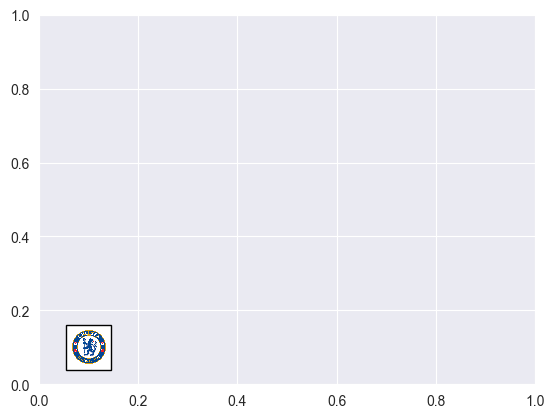

In [117]:
import matplotlib.pyplot as plt

import numpy as np

# Load the image
img = Image.open('../../../../../Downloads/R.png')

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image at specific coordinates (replace 'x' and 'y' with your coordinates)
imagebox = OffsetImage(img, zoom=0.01)
ab = AnnotationBbox(imagebox, (0.1, 0.1))
ax.add_artist(ab)

# Display the plot
plt.show()


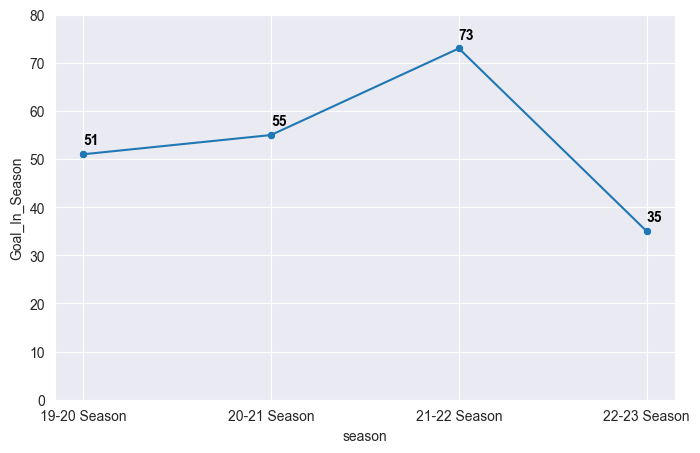

In [108]:
chelsea_goal = df[df['name'] == 'Chelsea FC']
chelsea_goal.reset_index(drop=True)

fig, axes = plt.subplots(figsize=(8,5))
ax = sns.lineplot(data=chelsea_goal, x='season', y='Goal_In_Season')
sns.scatterplot(data=chelsea_goal, x='season', y='Goal_In_Season', ax=ax)
plt.ylim(0, 80)

# Add text above each marker
for line in range(0,chelsea_goal.shape[0]):
     ax.text(
         chelsea_goal.iloc[line, 0], 
         chelsea_goal.iloc[line, 2]+2, 
         chelsea_goal.iloc[line, 2], 
         horizontalalignment='left', 
         size='medium', 
         color='black', 
         weight='semibold'
         )

plt.show()